>  ***To be merged in the original notebook***

## Part 2.2 Spectral-based novelty by madmom

Madmom is a python toolbox that does some state-of-the-art rhythm processing for you. The repository is here (along with some tutorials):

https://github.com/CPJKU/madmom

In order to get better novelty features, you can use the code in the following tutorial as starting point:

https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb

You can **run this tutorial as an addition, if you want to understand more** about state-of-the-art signal processing.

In order to use madmom in colab, I have to install it as follows, and to restart the runtime...which means this is better done in a separate python notebook. In order to re-import all libraries and create all needed variables again this separate notebook should start as:



In [ ]:
!pip install pydub
!pip install madmom
!pip install librosa

In [ ]:
# Install python library madmom, for onset detection and beat tracking
# !pip install --force-reinstall madmom

In [5]:
import madmom

In [88]:
import librosa
import librosa.display
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import madmom
from scipy.ndimage.filters import maximum_filter
import IPython.display as ipd

filename = 'drumloop120_mono.wav'#put your file
root_path = 'labdata'#put your path

In [89]:
_, sample_rate = madmom.io.audio.load_wave_file(os.path.join(root_path,filename))

In [90]:
def moving_average(x, w):
    # w: avg window size
    return np.convolve(x, np.ones(w), 'same') /((2*w)+1) 

In [93]:
# use madmom to get the spectrogram in log scale
# a short window (30ms, and 10ms hop size)
frame_size = int(sample_rate * 30 * 1e-3)
hop_size = int(sample_rate * 10 * 1e-3)
spec = madmom.audio.spectrogram.LogarithmicSpectrogram(os.path.join(root_path,filename), mul=100, frame_size=frame_size, hop_size=hop_size, fft_size=8192)
# calculate the difference
diff = np.diff(spec, axis=0)
# keep only the positive differences
pos_diff = np.maximum(0, diff)
# sum everything to get the spectral flux
sf = np.sum(pos_diff, axis=1)

In [94]:
# local avg
Fs_nov = sample_rate/hop_size # novelty rate
big_m_ms = 600 # window size: This value needs to be high enough that it takes several windows to get the average
big_m = int(big_m_ms*Fs_nov*1e-3)
avg = moving_average(sf, big_m)
# obtain values above avg
pos_sf = np.maximum(0, sf-avg)
# normalize so that max is 1
norm_sf = (pos_sf - np.min(pos_sf))/np.ptp(pos_sf)

In [95]:
# obtain onsets
# by thresholding the obtained function, with a threshold of 0.5. 
# (Hint: the stem function from the matplotlib does that plotting for you)
norm_sf_thr = [1 if item >= 0.5 else 0 for item in norm_sf]
t = list(range(len(norm_sf)))

Text(0, 0.5, 'Amplitude')

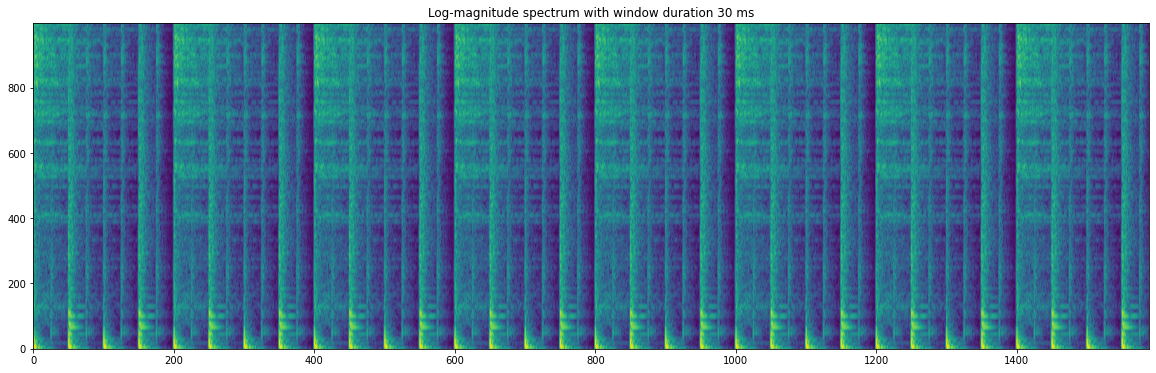

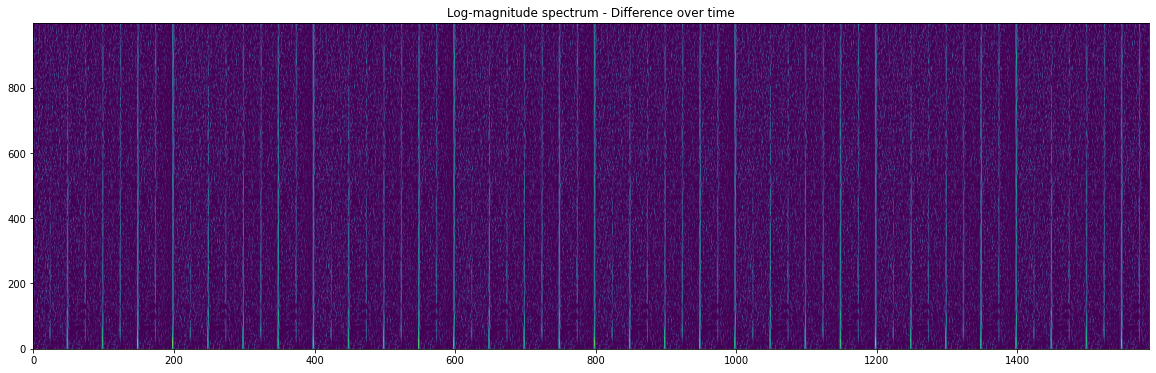

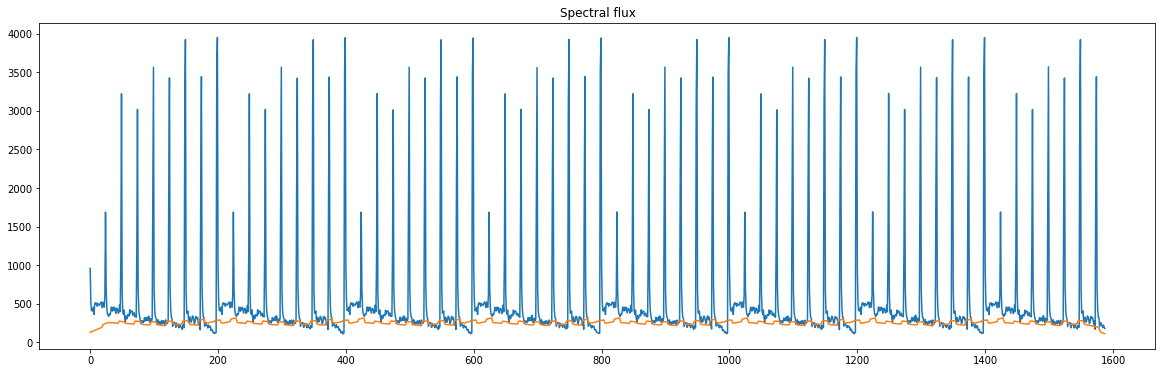

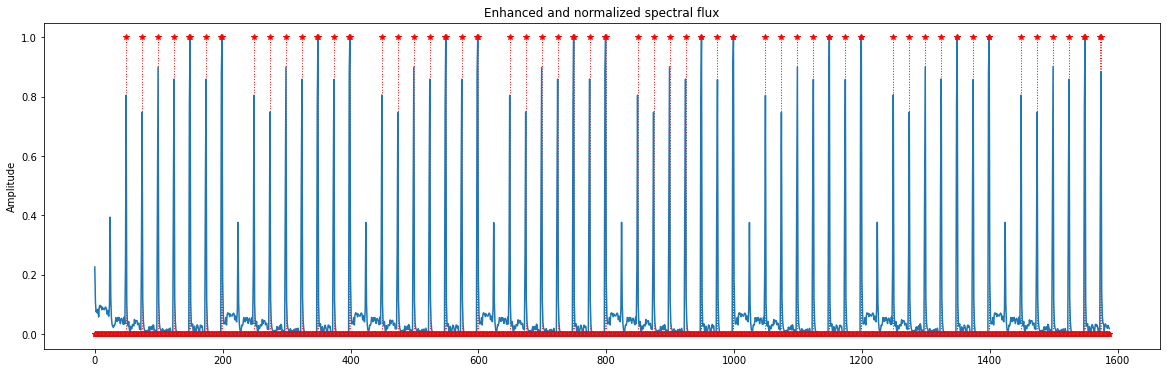

In [96]:
# plot
plt.rcParams["figure.figsize"] = (20,6)
# spectrogram
plt.figure()
plt.imshow(spec[:, :1000].T, origin='lower', aspect='auto')
plt.title('Log-magnitude spectrum with window duration 30 ms')
# plt.ylabel('Frequency [kHz]')
# plt.xlabel('Time [s]')
# diff over time
plt.figure()
plt.imshow(pos_diff[:, :1000].T, origin='lower', aspect='auto')
plt.title('Log-magnitude spectrum - Difference over time')
# plt.ylabel('Frequency [kHz]')
# plt.xlabel('Time [s]')
# spec flux
plt.figure()
plt.plot(sf)
plt.plot(avg, color='tab:orange')
plt.title('Spectral flux')
# plt.ylabel('Amplitude')
# plt.xlabel('Time [s]')
# spec func
plt.figure()
plt.plot(norm_sf)
markerline, stemlines, baseline = plt.stem(t, norm_sf_thr, ':', '*', 'C0:')
plt.setp(stemlines, 'color', 'r', 'linewidth', 1)
plt.setp(markerline, 'color', 'r', 'linewidth', 1)
plt.title('Enhanced and normalized spectral flux')
plt.ylabel('Amplitude')
# plt.xlabel('Time [s]')

## Part 2.4 Beat Tracking

In this part you will use two beat trackers, which are available in python:



1.   The librosa beat tracker, which is the dynamic programming approach presented in the book. An example for how to run the librosa beat tracker: https://musicinformationretrieval.com/beat_tracking.html

2.   And the madmom beat tracker, which is using deep learning. 

Apply both beat trackers to audio examples having the following three characteristics:

1. stable tempo, strong onsets (for instance, the drum loop example) 
2. instable tempo, strong onsets (for instance, the cretansyrtos) 
3. weak energy onsets (for instance, a string quartet or a choir performance) 

Provide plots for the waveform with the beats overlaid (using vlines or stem). Also listen to the beat tracking results, which you can do with code that looks somewhat as follows:



In [67]:
import IPython.display as ipd

In [68]:
def beat_plot(x, beat_times, filename, tracker="librosa"):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, alpha=0.6)
    plt.vlines(beat_times, -1, 1, color='r')
    plt.ylim(-1, 1)
    plt.xlabel("Time (s)")
    plt.title(f"Beat tracking with {tracker}: {filename}") 

In [79]:
def beat_librosa(filename, root_path="labdata"):
    # filename = 'cretansyrtos.wav'#put your file
    # root_path = 'labdata'#put your path
    # load audio file
    x, sr = librosa.load(os.path.join(root_path, filename))
    try:
        duration = 30 # s
        x = x[:int(duration*sr)]
    except:
        print("audio is shorter than 30ms")
    tempo, beat_times = librosa.beat.beat_track(x, sr=sr, start_bpm=60, units='time')
    # plot beats
    beat_plot(x, beat_times, filename, tracker="librosa")
    # listen to the beat tracking results
    clicks = librosa.clicks(beat_times, sr=sr, length=len(x))

    return x+clicks

For tracking with madmom, your code should look someshat as shown below. Note that in order to run madmom, I need to install it with the --force-install option, so it might be better to do that in a separate python notebook. A nice example that applies both librosa and madmom is here: https://www.analyticsvidhya.com/blog/2018/02/audio-beat-tracking-for-music-information-retrieval/

In [80]:
def beat_madmom(filename, root_path="labdata"):
    # load audio file
    x, sr = librosa.load(os.path.join(root_path, filename))
    # madmom processors
    import madmom
    proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
    act = madmom.features.beats.RNNBeatProcessor()(os.path.join(root_path,filename))
    beat_times = proc(act)
    # plot 30 seconds
    try:
        duration = 30 # s
        x = x[:int(duration*sr)]
    except:
        print("audio is shorter than 30ms")
    # plot beats
    beat_plot(x, beat_times, filename, tracker="madmom")
    # listen to the beat tracking results
    clicks = librosa.clicks(beat_times, sr=sr, length=len(x))

    return x+clicks

Report what differences you observe (mainly by listening to the audio with the clicks for the beats) between the beat tracking outputs obtained from the two algorithms. Why do you think these differences emerge? (Given what you know from the book chapter and the from example on the analyticsvidhya website)

The plot of waveform and beats I get for the cretansyrtos example using librosa:

![](https://drive.google.com/uc?id=1l1YtJjrCHzaGUDEQ9O4UBafarf983CvW)

The plot of waveform and beats I get for the cretansyrtos example using madmom:

![](https://drive.google.com/uc?id=1L5LHO2EwgHgg8ypuj57gaj2j0eboCa5k)

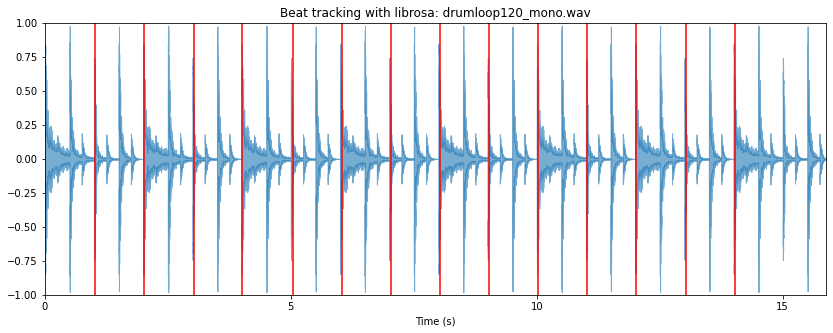

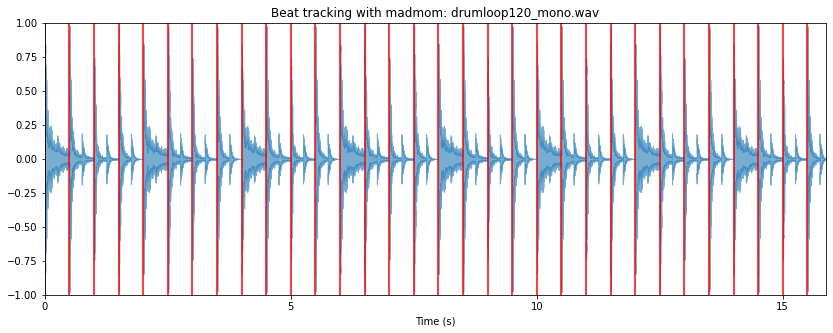

In [73]:
# 1. stable tempo, strong onsets (for instance, the drum loop example)
x_clicks_1 = beat_librosa("drumloop120_mono.wav")
x_clicks_2 = beat_madmom("drumloop120_mono.wav")

In [74]:
print(f"librosa")
ipd.Audio(x_clicks_1, rate=sr)

librosa


In [75]:
print(f"madmom")
ipd.Audio(x_clicks_2, rate=sr)

madmom


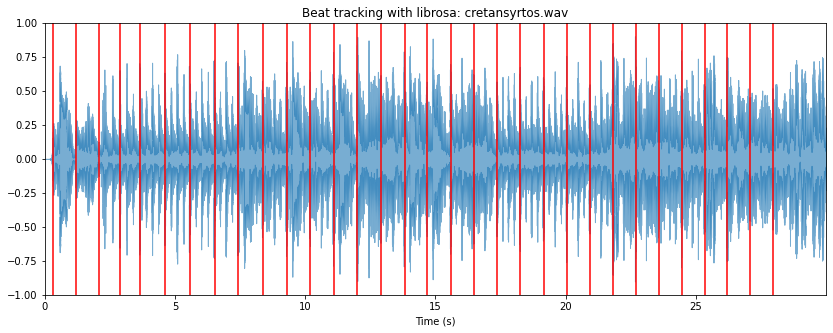

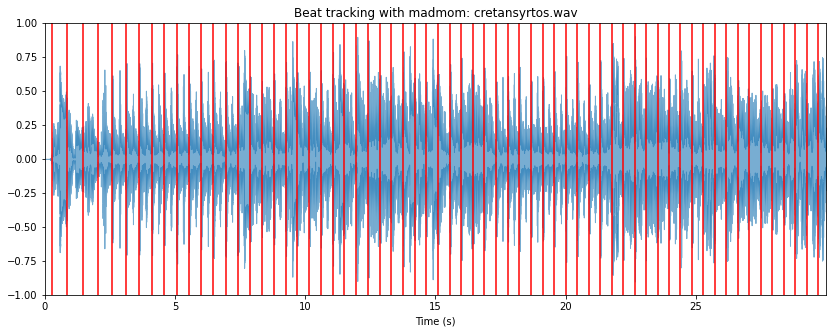

In [81]:
# 2. instable tempo, strong onsets (for instance, the cretansyrtos)
x_clicks_1 = beat_librosa("cretansyrtos.wav")
x_clicks_2 = beat_madmom("cretansyrtos.wav")

In [82]:
print(f"librosa")
ipd.Audio(x_clicks_1, rate=sr)

librosa


In [83]:
print(f"madmom: tempo {tempo_2}")
ipd.Audio(x_clicks_2, rate=sr)

madmom: tempo 60.09265988372093


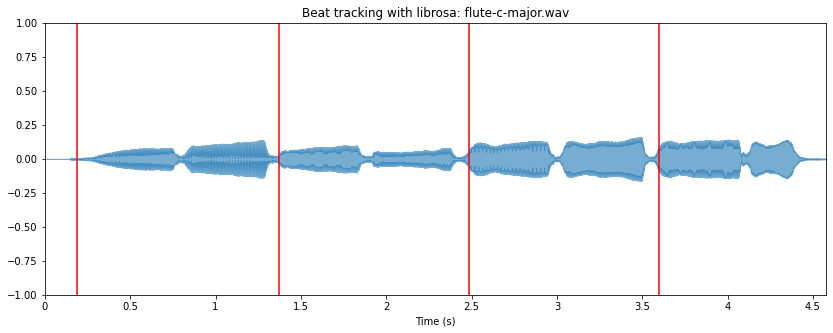

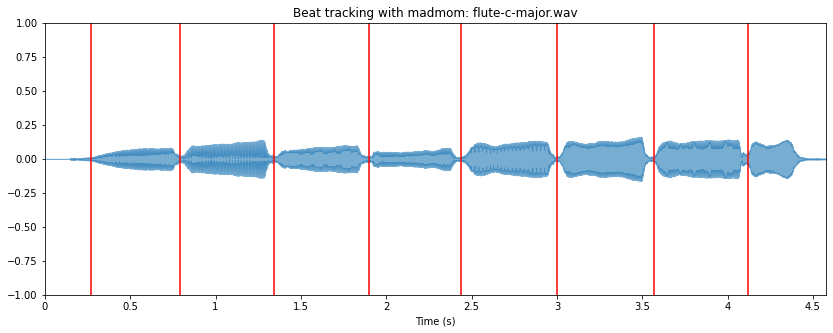

In [84]:
# 3. weak energy onsets (for instance, a string quartet or a choir performance)
x_clicks_1 = beat_librosa("flute-c-major.wav")
x_clicks_2 = beat_madmom("flute-c-major.wav")

In [85]:
print(f"librosa: tempo {tempo_1}")
ipd.Audio(x_clicks_1, rate=sr)

librosa: tempo 67.99958881578948


In [86]:
print(f"madmom: tempo {tempo_2}")
ipd.Audio(x_clicks_2, rate=sr)

madmom: tempo 60.09265988372093


Differences and why: In cases 1 and 3, Madmom gives a tempo approximately twice as much as librosa.
In case 2, cretansyrtos.wav has tempo variantion and it is probably the cause of inaccurate results from librosa. However, madmom is able to handle sudden tempo change.